In [2]:
# https://keras.io/examples/timeseries/timeseries_classification_from_scratch/


import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss

# fix random seed for reproducibility
tf.random.set_seed(7)

In [3]:
df = pd.read_csv("cleanedTemporalData.csv").set_index('PatientID')

X = []
y = []

for id, group in df.groupby('PatientID'):
    tempGroup = group.reset_index()
    
    tempGroup = tempGroup.drop(['PatientID', 'Mortality14Days'], axis=1)

    tempGroup = tempGroup.fillna(0)

    X.append(tempGroup.T.values)
    y.append(group['Mortality14Days'].values[0])


X = np.array(X)
y = np.array(y)


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)

(767, 12, 48) (767,)


In [4]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [5]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

weights = pd.Series(y).value_counts().values

classWeights = {x : 1/weights[x] for x in np.unique(y)}

print(classWeights)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
    class_weight = classWeights,
)

{0: 0.0010822510822510823, 1: 0.02857142857142857}
Epoch 1/500
20/20 [==============================] - 2s 21ms/step - loss: 0.0016 - sparse_categorical_accuracy: 0.4225 - val_loss: 0.5363 - val_sparse_categorical_accuracy: 0.8052 - lr: 0.0010
Epoch 2/500
20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - sparse_categorical_accuracy: 0.4454 - val_loss: 0.4851 - val_sparse_categorical_accuracy: 0.7857 - lr: 0.0010
Epoch 3/500
20/20 [==============================] - 0s 6ms/step - loss: 0.0012 - sparse_categorical_accuracy: 0.5661 - val_loss: 0.5738 - val_sparse_categorical_accuracy: 0.7013 - lr: 0.0010
Epoch 4/500
20/20 [==============================] - 0s 6ms/step - loss: 0.0010 - sparse_categorical_accuracy: 0.6574 - val_loss: 0.6325 - val_sparse_categorical_accuracy: 0.6688 - lr: 0.0010
Epoch 5/500
20/20 [==============================] - 0s 6ms/step - loss: 0.0010 - sparse_categorical_accuracy: 0.7798 - val_loss: 0.6522 - val_sparse_categorical_accuracy: 0.6429 -

In [6]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])

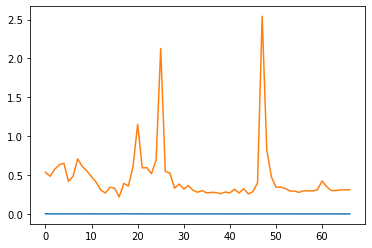

In [7]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
plt.show()

In [9]:
preds = np.argmax(model.predict(x_test), axis=1)
display(f1_score(y_test, preds, average="macro"))

6/6 [==============================] - 0s 2ms/step


0.5336976320582878